Regularized logistic regression
===============================

*Key ideas:* L1 regularization, logistic regression, simulation study

In this notebook we demonstrate L1 penalized logistic regression (the "logistic lasso") using several data sets relating to the utilization of medical services.

Here are the usual import statements:

In [31]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("notebook")
import patsy
from statsmodels.discrete.discrete_model import Logit
import numpy as np
import pandas as pd

## Data set 1

We start with a data set that records the number of annual visits to the doctor's office for each subject, along with three possible predictor variables.  

The data set is documented [here](http://vincentarelbundock.github.io/Rdatasets/doc/Ecdat/Doctor.html).

To make things more interesting we also include all the pairwise interactions among the predictors.

In [22]:
data = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/Doctor.csv")
data["children x access"] = data["children"] * data["access"]
data["children x health"] = data["children"] * data["health"]
data["access x health"] = data["access"] * data["health"]

In [23]:
data.head()

,Unnamed: 0,doctor,children,access,health,children x access,children x health,access x health
0,1,0,1,0.50,0.495,0.50,0.495,0.24750
1,2,1,3,0.17,0.520,0.51,1.560,0.08840
2,3,0,4,0.42,-1.227,1.68,-4.908,-0.51534
3,4,0,2,0.33,-1.524,0.66,-3.048,-0.50292
4,5,11,1,0.67,0.173,0.67,0.173,0.11591


For regularized regression, it is simplest if we use the same penalty weight for all predictor variables (except for the intercept which is usually not penalized).  It is easier to motivate using the same penalty weight for all variables if we first standardize the variables.

In [24]:
vnames = ["children", "access", "health", "children x access", "children x health", "access x health"]
exog = data[vnames]
exog -= exog.mean(0)
exog /= exog.std(0)

L1 penalized regression requires a tuning parameter (the weight of the penalty function) to be specified.  To avoid needing to select a single penalty weight, here we look at the *solution paths*, which are the paths followed by the regression coefficients as the penalty weight is varied.  To do this, we specify a sequence of tuning parameter values.

In [25]:
avals = np.linspace(1, 100, 50)

The number of doctor visits in one year is recorded for each subject.  To avoid the difficulty of modeling the long right tail in these numbers, we dichotomize the number of visits at various points and use regularized logistic regression.  Here we fit regularized logistic regression models using thresholds 1, 2, 3, and 4 for the number of annual visits, thereby creating a binary dependent variable.

In [26]:
exog = np.concatenate((np.ones((exog.shape[0],1)), exog), axis=1)
vnames.insert(0, "Intercept")
params = {}
for tr in range(1, 5):
    pr = []
    endog = 1*(data["doctor"] >= tr)
    for a in avals:
        alpha = a * np.ones(exog.shape[1], dtype=np.float64)
        alpha[0] = 0 # Don't penalize the intercept
        mod = Logit(endog, exog)
        rslt = mod.fit_regularized(alpha=alpha, disp=False)
        pr.append(rslt.params)
    params[tr] = np.asarray(pr)

Next we have a helper function that plots the solution paths from a given dichotomization threshold.

In [27]:
def make_plot(tr):
    plt.figure(figsize=(10,5))
    plt.clf()
    plt.axes([0.1, 0.1, 0.67, 0.8])
    pr = params[tr]
    ag = []
    for k in range(pr.shape[1]):
        v, = plt.plot(avals, pr[:,k], linestyle=["-", "--", ":"][k // 7])
        ag.append(v)
    leg = plt.figlegend(ag, vnames, "center right")
    leg.draw_frame(False)
    plt.xlabel("Penalty weight", size=17)
    plt.ylabel("Coefficient", size=17)
    plt.title(">=%d visit%s/year" % (tr, "s" if tr > 1 else ""), size=17)
    plt.grid(True)

The following plots suggest that (not surprisingly), people in poor health visit the doctor more often.  In addition, there is a positive interaction between poor health and both access to health care and the number of children (i.e. people in poor health with access to medical care visit the doctor more often than people in poor health without access to medical care, and people in poor health with children visit the doctor more often than people in poor health without children).  Note that as with any regression involving interactions, it is difficult to interpret the main effects.

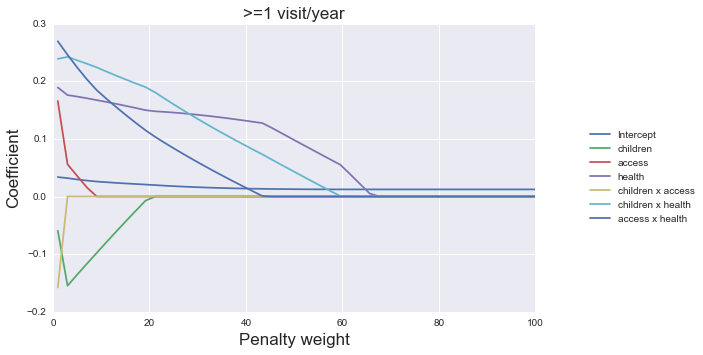

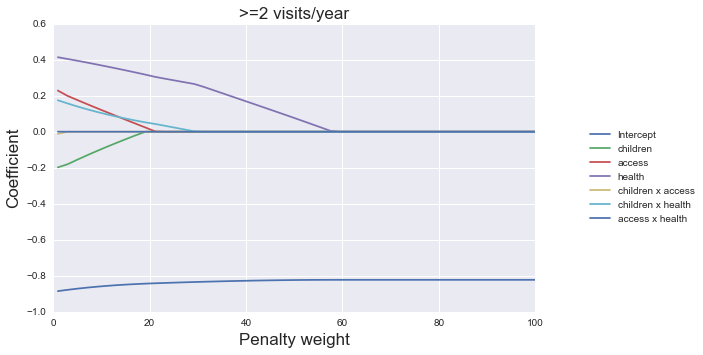

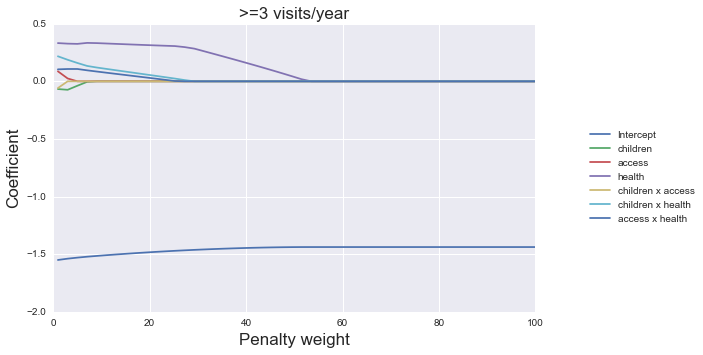

In [32]:
make_plot(1)
make_plot(2)
make_plot(3)

## Data set 2

Next we look at a much larger data set that has many more subjects and more predictor variables.

The data set is documented [here](http://vincentarelbundock.github.io/Rdatasets/doc/Ecdat/DoctorContacts.html).

In [33]:
data = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/DoctorContacts.csv")
endog = data["mdu"]
vnames = list(data.columns)
vnames.remove("mdu")
vnames.remove("Unnamed: 0")
exog = pd.DataFrame(data[vnames])

It seems that we need to explicitly convert boolean variables to numbers:

In [34]:
for k in range(exog.shape[1]):
    if exog.iloc[:,k].dtype == type(True):
        exog.iloc[:,k] = exog.iloc[:,k].astype(np.int32)

We also need to convert the categorical variables to numeric values, and, as above, we standardize the predictors.

In [35]:
exog["health"] = pd.Categorical.from_array(exog["health"]).labels
exog["sex"] = pd.Categorical.from_array(exog["sex"]).labels
exog = exog.convert_objects(convert_numeric=True)
exog -= exog.mean(0)
exog /= exog.std(0)
exog["Intercept"] = 1.

-c:1: FutureWarning: 'labels' is deprecated. Use 'codes' instead
-c:2: FutureWarning: 'labels' is deprecated. Use 'codes' instead
/home/gus/anaconda2/envs/stack2/lib/python2.7/site-packages/pandas/util/decorators.py:89: FutureWarning: the 'convert_numeric' keyword is deprecated, use 'numeric' instead
  return func(*args, **kwargs)


Here we fit regularized logistic regression models for the outcome of having more than 1 medical contact in a year (mdu > 1).

In [36]:
endog1 = 1*(endog > 1)
avals = np.linspace(1, 2500, 50)
pr = []
for a in avals:
    mod = Logit(endog1, exog)
    rslt = mod.fit_regularized(alpha=a, disp=False)
    pr.append(rslt.params)
pr = np.asarray(pr)
params = {2: pr}

Here is a plot of the solution paths:

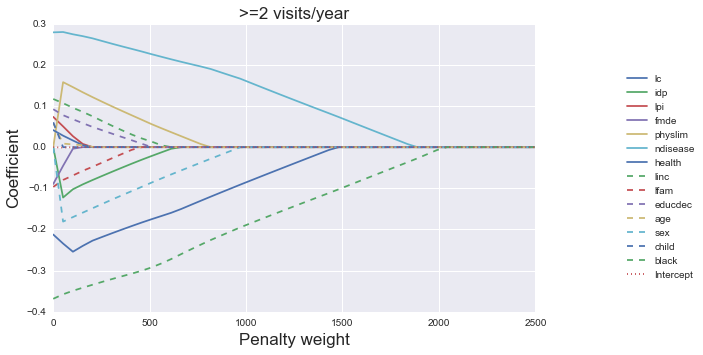

In [37]:
vnames = exog.columns
make_plot(2)